# 데이터 로드

In [2]:
# manipulated
import gdown

url = "https://drive.google.com/uc?id=1Dy8OjqVSQ4gvZiF70LruptrjccgIm9J3"
gdown.download(url,'/content/manipulated.zip',quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Dy8OjqVSQ4gvZiF70LruptrjccgIm9J3
From (redirected): https://drive.google.com/uc?id=1Dy8OjqVSQ4gvZiF70LruptrjccgIm9J3&confirm=t&uuid=a8608111-9d26-4cc0-952f-8a8b5d124400
To: /content/manipulated.zip
100%|██████████| 3.58G/3.58G [00:27<00:00, 132MB/s]


'/content/manipulated.zip'

In [3]:
!unzip -q /content/manipulated.zip -d /content

In [4]:
# original

url = "https://drive.google.com/uc?id=1F3NvAGSz-6kDY5SPZjZy6wZYE89iemD4"
gdown.download(url,'/content/original.zip',quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1F3NvAGSz-6kDY5SPZjZy6wZYE89iemD4
From (redirected): https://drive.google.com/uc?id=1F3NvAGSz-6kDY5SPZjZy6wZYE89iemD4&confirm=t&uuid=0868dd3e-48a1-4291-a3b9-68c678702091
To: /content/original.zip
100%|██████████| 435M/435M [00:02<00:00, 145MB/s]


'/content/original.zip'

In [5]:
!unzip -q /content/original.zip -d /content

In [6]:
!mv /content/DFD_manipulated_sequences /content/manipulated

In [7]:
!mv "/content/DFD_original sequences" "/content/original"

# 모델 구현

In [8]:
# ------------------ 0. Import (필수) ------------------
import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.video import swin3d_t, Swin3D_T_Weights
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

In [9]:
# ------------------ 1. 데이터셋 클래스 ------------------
class DeepfakeVideoDataset(Dataset):
    def __init__(self, root_dir, frame_num=72, size=224, face_count_filter=None):
        '''
        face_count_filter: None(전체), 1(얼굴 1개 비디오), 2(2개 이상 비디오)
        '''
        self.data = []
        self.labels = []
        self.video_face_count = {}  # 비디오별 face idx 개수 기록
        self.frame_num = frame_num
        self.size = size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        for label, subdir in enumerate(['original', 'manipulated']):
            sub_path = os.path.join(root_dir, subdir)
            video_dict = {}
            for img_path in glob.glob(os.path.join(sub_path, "*.jpg")):
                fname = os.path.basename(img_path)
                main, ext = os.path.splitext(fname)
                parts = main.split('_')
                if len(parts) < 3:
                    continue
                try:
                    face_idx = int(parts[-1])
                    fnum = int(parts[-2])
                except ValueError:
                    continue
                video_id = '_'.join(parts[:-2])
                if video_id not in video_dict:
                    video_dict[video_id] = {}
                if face_idx not in video_dict[video_id]:
                    video_dict[video_id][face_idx] = {}
                video_dict[video_id][face_idx][fnum] = img_path
            # 비디오별 face 개수 필터링
            for video_id, people_dict in video_dict.items():
                face_count = len(people_dict)
                self.video_face_count[video_id] = face_count
                if face_count_filter is not None:
                    if face_count_filter == 1 and face_count != 1:
                        continue
                    elif face_count_filter == 2 and face_count < 2:
                        continue
                for face_idx, frame_dict in people_dict.items():
                    if len(frame_dict) == self.frame_num:
                        frames = [frame_dict[fidx] for fidx in range(self.frame_num)]
                        self.data.append((video_id, face_idx, frames))
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        video_id, face_idx, frames = self.data[idx]
        label = self.labels[idx]
        imgs = []
        for img_path in frames:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.size, self.size))
            img = self.transform(img)
            imgs.append(img)
        video_tensor = torch.stack(imgs, dim=0).permute(1, 0, 2, 3)
        return video_tensor, label, video_id, face_idx


In [10]:
# ------------------ 2. 얼굴 1개 (Train/Val), 2개 이상 (Test) 데이터셋 분리 ------------------
root_dir = '/content'  # 폴더 경로 맞게 변경

# 얼굴 1개 (Train/Val)
dataset_1face = DeepfakeVideoDataset(root_dir, frame_num=72, size=224, face_count_filter=1)
indices = np.arange(len(dataset_1face))
labels = [dataset_1face.labels[i] for i in range(len(dataset_1face))]
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)
train_set = Subset(dataset_1face, train_idx)
val_set = Subset(dataset_1face, val_idx)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)

# 얼굴 2개 이상 (Test)
dataset_2face = DeepfakeVideoDataset(root_dir, frame_num=72, size=224, face_count_filter=2)
test_loader = DataLoader(dataset_2face, batch_size=4, shuffle=False, num_workers=2)


In [11]:
# ------------------ 3. 모델 및 로스 ------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        BCE = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE
        return F_loss.mean()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = Swin3D_T_Weights.DEFAULT
model = swin3d_t(weights=weights)
model.head = nn.Linear(model.head.in_features, 2)  # 이진 분류
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = FocalLoss(alpha=0.1, gamma=2)


Downloading: "https://download.pytorch.org/models/swin3d_t-7615ae03.pth" to /root/.cache/torch/hub/checkpoints/swin3d_t-7615ae03.pth
100%|██████████| 122M/122M [00:00<00:00, 207MB/s]


In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, average_precision_score

In [ ]:
# ------------------ 4. (기존 학습/평가 루프 사용) ------------------
num_epochs = 30
patience = 10
best_auc = 0
pat = 0
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': [],
    'train_auc': [], 'val_auc': [],
    'train_prc': [], 'val_prc': [],  # PR AUC (average_precision_score)
    'train_prec': [], 'val_prec': [],
    'train_rec': [], 'val_rec': [],
    'train_mcc': [], 'val_mcc': []
}


for epoch in range(num_epochs):
    # --- Train ---
    model.train()
    train_loss, preds, targets, probs = [], [], [], []
    for video_tensor, label, video_id, face_idx in tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]'):
        video_tensor = video_tensor.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        out = model(video_tensor)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        prob = out.softmax(-1)[:, 1].detach().cpu().numpy()
        pred_label = (prob > 0.4).astype(int)
        preds += list(pred_label)
        targets += list(label.cpu().numpy())
        probs += list(prob)
    train_loss = np.mean(train_loss)
    train_acc = accuracy_score(targets, preds)
    train_f1 = f1_score(targets, preds)
    train_auc = roc_auc_score(targets, probs)
    train_prc = average_precision_score(targets, probs)   # PR-AUC
    train_prec = precision_score(targets, preds)
    train_rec = recall_score(targets, preds)
    train_mcc = matthews_corrcoef(targets, preds)

    # --- Validation ---
    model.eval()
    val_loss, preds, targets, probs = [], [], [], []
    val_video_ids, val_face_idxs = [], []
    with torch.no_grad():
        for video_tensor, label, video_id, face_idx in tqdm(val_loader, desc=f'Epoch {epoch+1} [Val]'):
            video_tensor = video_tensor.to(device)
            label = label.to(device)
            out = model(video_tensor)
            loss = criterion(out, label)
            val_loss.append(loss.item())
            prob = out.softmax(-1)[:, 1].cpu().numpy()
            pred_label = (prob > 0.4).astype(int)
            preds += list(pred_label)
            targets += list(label.cpu().numpy())
            probs += list(prob)
            if isinstance(video_id, (list, tuple)):
                val_video_ids += list(video_id)
                val_face_idxs += list(face_idx)
            else:
                val_video_ids.append(video_id)
                val_face_idxs.append(face_idx)
    val_loss = np.mean(val_loss)
    val_acc = accuracy_score(targets, preds)
    val_f1 = f1_score(targets, preds)
    val_auc = roc_auc_score(targets, probs)
    val_prc = average_precision_score(targets, probs)
    val_prec = precision_score(targets, preds)
    val_rec = recall_score(targets, preds)
    val_mcc = matthews_corrcoef(targets, preds)

    # 기록
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    history['train_prc'].append(train_prc)
    history['val_prc'].append(val_prc)
    history['train_prec'].append(train_prec)
    history['val_prec'].append(val_prec)
    history['train_rec'].append(train_rec)
    history['val_rec'].append(val_rec)
    history['train_mcc'].append(train_mcc)
    history['val_mcc'].append(val_mcc)

    print(
        f"[{epoch+1}] "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
        f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, "
        f"train_f1={train_f1:.4f}, val_f1={val_f1:.4f}, "
        f"train_auc={train_auc:.4f}, val_auc={val_auc:.4f}, "
        f"train_prc={train_prc:.4f}, val_prc={val_prc:.4f}, "
        f"train_prec={train_prec:.4f}, val_prec={val_prec:.4f}, "
        f"train_rec={train_rec:.4f}, val_rec={val_rec:.4f}, "
        f"train_mcc={train_mcc:.4f}, val_mcc={val_mcc:.4f}"
    )

    # Early Stopping & Checkpoint
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_videoswin3.pth')
        pat = 0
    else:
        pat += 1
    if pat >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[1] train_loss=0.0068, val_loss=0.0062, train_acc=0.9131, val_acc=0.8959, train_f1=0.9535, val_f1=0.9450, train_auc=0.8250, val_auc=0.9091, train_prc=0.9697, val_prc=0.9865, train_prec=0.9146, val_prec=0.8957, train_rec=0.9957, val_rec=1.0000, train_mcc=0.4037, val_mcc=0.1352


Epoch 2 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[2] train_loss=0.0044, val_loss=0.0079, train_acc=0.9332, val_acc=0.8980, train_f1=0.9637, val_f1=0.9460, train_auc=0.9491, val_auc=0.8648, train_prc=0.9906, val_prc=0.9750, train_prec=0.9369, val_prec=0.8976, train_rec=0.9921, val_rec=1.0000, train_mcc=0.5867, val_mcc=0.1914


Epoch 3 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[3] train_loss=0.0041, val_loss=0.0024, train_acc=0.9386, val_acc=0.9653, train_f1=0.9666, val_f1=0.9808, train_auc=0.9509, val_auc=0.9888, train_prc=0.9931, val_prc=0.9987, train_prec=0.9408, val_prec=0.9714, train_rec=0.9939, val_rec=0.9903, train_mcc=0.6265, val_mcc=0.8071


Epoch 4 [Val]: 100%|██████████| 116/116 [00:38<00:00,  3.05it/s]


[4] train_loss=0.0025, val_loss=0.0033, train_acc=0.9620, val_acc=0.9610, train_f1=0.9791, val_f1=0.9785, train_auc=0.9811, val_auc=0.9915, train_prc=0.9972, val_prc=0.9990, train_prec=0.9641, val_prec=0.9624, train_rec=0.9945, val_rec=0.9951, train_mcc=0.7838, val_mcc=0.7780


Epoch 5 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[5] train_loss=0.0017, val_loss=0.0019, train_acc=0.9663, val_acc=0.9740, train_f1=0.9814, val_f1=0.9856, train_auc=0.9920, val_auc=0.9926, train_prc=0.9989, val_prc=0.9991, train_prec=0.9686, val_prec=0.9762, train_rec=0.9945, val_rec=0.9951, train_mcc=0.8106, val_mcc=0.8565


Epoch 6 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[6] train_loss=0.0014, val_loss=0.0022, train_acc=0.9728, val_acc=0.9631, train_f1=0.9849, val_f1=0.9797, train_auc=0.9953, val_auc=0.9927, train_prc=0.9995, val_prc=0.9991, train_prec=0.9767, val_prec=0.9625, train_rec=0.9933, val_rec=0.9976, train_mcc=0.8500, val_mcc=0.7913


Epoch 7 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[7] train_loss=0.0011, val_loss=0.0020, train_acc=0.9804, val_acc=0.9761, train_f1=0.9891, val_f1=0.9867, train_auc=0.9967, val_auc=0.9945, train_prc=0.9996, val_prc=0.9994, train_prec=0.9820, val_prec=0.9855, train_rec=0.9964, val_rec=0.9879, train_mcc=0.8932, val_mcc=0.8733


Epoch 8 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[8] train_loss=0.0024, val_loss=0.0055, train_acc=0.9745, val_acc=0.9132, train_f1=0.9858, val_f1=0.9537, train_auc=0.9848, val_auc=0.9312, train_prc=0.9962, val_prc=0.9904, train_prec=0.9779, val_prec=0.9115, train_rec=0.9939, val_rec=1.0000, train_mcc=0.8594, val_mcc=0.4092


Epoch 9 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.06it/s]


[9] train_loss=0.0015, val_loss=0.0041, train_acc=0.9739, val_acc=0.9696, train_f1=0.9856, val_f1=0.9832, train_auc=0.9949, val_auc=0.9857, train_prc=0.9994, val_prc=0.9981, train_prec=0.9745, val_prec=0.9716, train_rec=0.9970, val_rec=0.9951, train_mcc=0.8555, val_mcc=0.8309


Epoch 10 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[10] train_loss=0.0017, val_loss=0.0025, train_acc=0.9728, val_acc=0.9501, train_f1=0.9849, val_f1=0.9728, train_auc=0.9940, val_auc=0.9921, train_prc=0.9993, val_prc=0.9991, train_prec=0.9767, val_prec=0.9492, train_rec=0.9933, val_rec=0.9976, train_mcc=0.8500, val_mcc=0.7079


Epoch 11 [Val]: 100%|██████████| 116/116 [00:38<00:00,  2.99it/s]


[11] train_loss=0.0004, val_loss=0.0018, train_acc=0.9924, val_acc=0.9870, train_f1=0.9958, val_f1=0.9927, train_auc=0.9997, val_auc=0.9954, train_prc=1.0000, val_prc=0.9995, train_prec=0.9922, val_prec=0.9927, train_rec=0.9994, val_rec=0.9927, train_mcc=0.9593, val_mcc=0.9315


Epoch 12 [Val]: 100%|██████████| 116/116 [00:39<00:00,  2.96it/s]


[12] train_loss=0.0022, val_loss=0.0015, train_acc=0.9750, val_acc=0.9696, train_f1=0.9862, val_f1=0.9831, train_auc=0.9843, val_auc=0.9944, train_prc=0.9969, val_prc=0.9993, train_prec=0.9768, val_prec=0.9761, train_rec=0.9957, val_rec=0.9903, train_mcc=0.8620, val_mcc=0.8332


Epoch 13 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[13] train_loss=0.0006, val_loss=0.0055, train_acc=0.9919, val_acc=0.9631, train_f1=0.9955, val_f1=0.9797, train_auc=0.9993, val_auc=0.9940, train_prc=0.9999, val_prc=0.9993, train_prec=0.9927, val_prec=0.9625, train_rec=0.9982, val_rec=0.9976, train_mcc=0.9564, val_mcc=0.7913


Epoch 14 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[14] train_loss=0.0020, val_loss=0.0025, train_acc=0.9739, val_acc=0.9675, train_f1=0.9855, val_f1=0.9820, train_auc=0.9882, val_auc=0.9876, train_prc=0.9985, val_prc=0.9985, train_prec=0.9773, val_prec=0.9693, train_rec=0.9939, val_rec=0.9951, train_mcc=0.8562, val_mcc=0.8179


Epoch 15 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[15] train_loss=0.0010, val_loss=0.0025, train_acc=0.9842, val_acc=0.9718, train_f1=0.9912, val_f1=0.9844, train_auc=0.9969, val_auc=0.9942, train_prc=0.9996, val_prc=0.9993, train_prec=0.9856, val_prec=0.9761, train_rec=0.9970, val_rec=0.9927, train_mcc=0.9146, val_mcc=0.8447


Epoch 16 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.11it/s]


[16] train_loss=0.0007, val_loss=0.0024, train_acc=0.9897, val_acc=0.9696, train_f1=0.9942, val_f1=0.9832, train_auc=0.9966, val_auc=0.9931, train_prc=0.9994, val_prc=0.9992, train_prec=0.9915, val_prec=0.9716, train_rec=0.9970, val_rec=0.9951, train_mcc=0.9447, val_mcc=0.8309


Epoch 17 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[17] train_loss=0.0008, val_loss=0.0016, train_acc=0.9875, val_acc=0.9761, train_f1=0.9930, val_f1=0.9868, train_auc=0.9986, val_auc=0.9952, train_prc=0.9998, val_prc=0.9994, train_prec=0.9897, val_prec=0.9785, train_rec=0.9964, val_rec=0.9951, train_mcc=0.9328, val_mcc=0.8691


Epoch 18 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.11it/s]


[18] train_loss=0.0012, val_loss=0.0036, train_acc=0.9772, val_acc=0.9328, train_f1=0.9873, val_f1=0.9637, train_auc=0.9967, val_auc=0.9876, train_prc=0.9996, val_prc=0.9985, train_prec=0.9802, val_prec=0.9320, train_rec=0.9945, val_rec=0.9976, train_mcc=0.8750, val_mcc=0.5830


Epoch 19 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[19] train_loss=0.0008, val_loss=0.0018, train_acc=0.9848, val_acc=0.9696, train_f1=0.9915, val_f1=0.9831, train_auc=0.9987, val_auc=0.9937, train_prc=0.9998, val_prc=0.9993, train_prec=0.9873, val_prec=0.9784, train_rec=0.9957, val_rec=0.9879, train_mcc=0.9179, val_mcc=0.8351


Epoch 20 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[20] train_loss=0.0011, val_loss=0.0018, train_acc=0.9859, val_acc=0.9783, train_f1=0.9921, val_f1=0.9880, train_auc=0.9974, val_auc=0.9952, train_prc=0.9997, val_prc=0.9994, train_prec=0.9874, val_prec=0.9809, train_rec=0.9970, val_rec=0.9951, train_mcc=0.9237, val_mcc=0.8816


Epoch 21 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[21] train_loss=0.0000, val_loss=0.0032, train_acc=0.9995, val_acc=0.9783, train_f1=0.9997, val_f1=0.9880, train_auc=1.0000, val_auc=0.9957, train_prc=1.0000, val_prc=0.9995, train_prec=0.9994, val_prec=0.9809, train_rec=1.0000, val_rec=0.9951, train_mcc=0.9971, val_mcc=0.8816


Epoch 22 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[22] train_loss=0.0009, val_loss=0.0030, train_acc=0.9880, val_acc=0.9544, train_f1=0.9933, val_f1=0.9750, train_auc=0.9980, val_auc=0.9891, train_prc=0.9998, val_prc=0.9987, train_prec=0.9909, val_prec=0.9557, train_rec=0.9957, val_rec=0.9951, train_mcc=0.9360, val_mcc=0.7366


Epoch 23 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[23] train_loss=0.0008, val_loss=0.0020, train_acc=0.9891, val_acc=0.9761, train_f1=0.9940, val_f1=0.9868, train_auc=0.9986, val_auc=0.9961, train_prc=0.9998, val_prc=0.9995, train_prec=0.9892, val_prec=0.9762, train_rec=0.9988, val_rec=0.9976, train_mcc=0.9416, val_mcc=0.8688


Epoch 24 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[24] train_loss=0.0014, val_loss=0.0028, train_acc=0.9804, val_acc=0.9740, train_f1=0.9891, val_f1=0.9855, train_auc=0.9946, val_auc=0.9751, train_prc=0.9993, val_prc=0.9963, train_prec=0.9820, val_prec=0.9785, train_rec=0.9964, val_rec=0.9927, train_mcc=0.8932, val_mcc=0.8574


Epoch 25 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.11it/s]


[25] train_loss=0.0011, val_loss=0.0017, train_acc=0.9832, val_acc=0.9783, train_f1=0.9906, val_f1=0.9879, train_auc=0.9965, val_auc=0.9963, train_prc=0.9996, val_prc=0.9996, train_prec=0.9838, val_prec=0.9855, train_rec=0.9976, val_rec=0.9903, train_mcc=0.9084, val_mcc=0.8840


Epoch 26 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[26] train_loss=0.0014, val_loss=0.0054, train_acc=0.9853, val_acc=0.9523, train_f1=0.9918, val_f1=0.9740, train_auc=0.9946, val_auc=0.9931, train_prc=0.9993, val_prc=0.9992, train_prec=0.9874, val_prec=0.9493, train_rec=0.9964, val_rec=1.0000, train_mcc=0.9208, val_mcc=0.7232


Epoch 27 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[27] train_loss=0.0003, val_loss=0.0029, train_acc=0.9967, val_acc=0.9675, train_f1=0.9982, val_f1=0.9818, train_auc=0.9998, val_auc=0.9873, train_prc=1.0000, val_prc=0.9984, train_prec=0.9970, val_prec=0.9830, train_rec=0.9994, val_rec=0.9806, train_mcc=0.9827, val_mcc=0.8303


Epoch 28 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]


[28] train_loss=0.0003, val_loss=0.0035, train_acc=0.9951, val_acc=0.9696, train_f1=0.9973, val_f1=0.9831, train_auc=0.9998, val_auc=0.9917, train_prc=1.0000, val_prc=0.9990, train_prec=0.9952, val_prec=0.9784, train_rec=0.9994, val_rec=0.9879, train_mcc=0.9740, val_mcc=0.8351


Epoch 29 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


[29] train_loss=0.0012, val_loss=0.0024, train_acc=0.9848, val_acc=0.9479, train_f1=0.9915, val_f1=0.9716, train_auc=0.9968, val_auc=0.9854, train_prc=0.9996, val_prc=0.9982, train_prec=0.9868, val_prec=0.9491, train_rec=0.9964, val_rec=0.9951, train_mcc=0.9177, val_mcc=0.6933


Epoch 30 [Val]: 100%|██████████| 116/116 [00:37<00:00,  3.12it/s]

[30] train_loss=0.0005, val_loss=0.0041, train_acc=0.9919, val_acc=0.9696, train_f1=0.9955, val_f1=0.9833, train_auc=0.9996, val_auc=0.9915, train_prc=1.0000, val_prc=0.9990, train_prec=0.9916, val_prec=0.9693, train_rec=0.9994, val_rec=0.9976, train_mcc=0.9564, val_mcc=0.8307


In [24]:
# ------------------ 5. Test(2명+) 비디오 level 추론 및 평가 ------------------
video_pred_dict = defaultdict(list)
video_target_dict = {}
model.load_state_dict(torch.load('best_videoswin3.pth', map_location=device))
model.eval()
with torch.no_grad():
    for video_tensor, label, video_id, face_idx in tqdm(test_loader, desc="Test [2 faces+]"):
        video_tensor = video_tensor.to(device)
        out = model(video_tensor)
        prob = out.softmax(-1)[:, 1].cpu().numpy()
        pred_label = (prob > 0.4).astype(int)
        for vid, pl, tar in zip(video_id, pred_label, label.cpu().numpy()):
            video_pred_dict[vid].append(pl)
            video_target_dict[vid] = tar

# 하나라도 1(조작)이면 조작 비디오
video_preds = []
video_targets = []
for vid in video_pred_dict:
    is_manip = (np.array(video_pred_dict[vid]) > 0).any()
    video_preds.append(int(is_manip))
    video_targets.append(video_target_dict[vid])


video_acc = accuracy_score(video_targets, video_preds)
video_f1 = f1_score(video_targets, video_preds)
video_auc = roc_auc_score(video_targets, video_preds)
video_mcc = matthews_corrcoef(video_targets, video_preds)
video_prec = precision_score(video_targets, video_preds, zero_division=0)
video_rec = recall_score(video_targets, video_preds, zero_division=0)
video_prc = average_precision_score(video_targets, video_preds)  # PR-AUC

print(f"Test (Video-level/2명 이상) acc={video_acc:.4f}, f1={video_f1:.4f}, auc={video_auc:.4f}, mcc={video_mcc:.4f}")
print(f"                        precision={video_prec:.4f}, recall={video_rec:.4f}, pr-auc={video_prc:.4f}")

Test [2 faces+]: 100%|██████████| 442/442 [02:31<00:00,  2.93it/s]

Test (Video-level/2명 이상) acc=0.9374, f1=0.9650, auc=0.8359, mcc=0.6719
                        precision=0.9650, recall=0.9650, pr-auc=0.9625


# 시각화

## 그래프

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

# history dict에는
# - train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, train_auc, val_auc, train_mcc, val_mcc
# - video_acc, video_f1, video_auc, video_mcc 등이 모두 들어있어야 합니다.

sns.set_theme(style="whitegrid", font_scale=1.2)
epochs = len(history['train_loss'])
x = np.arange(1, epochs+1)

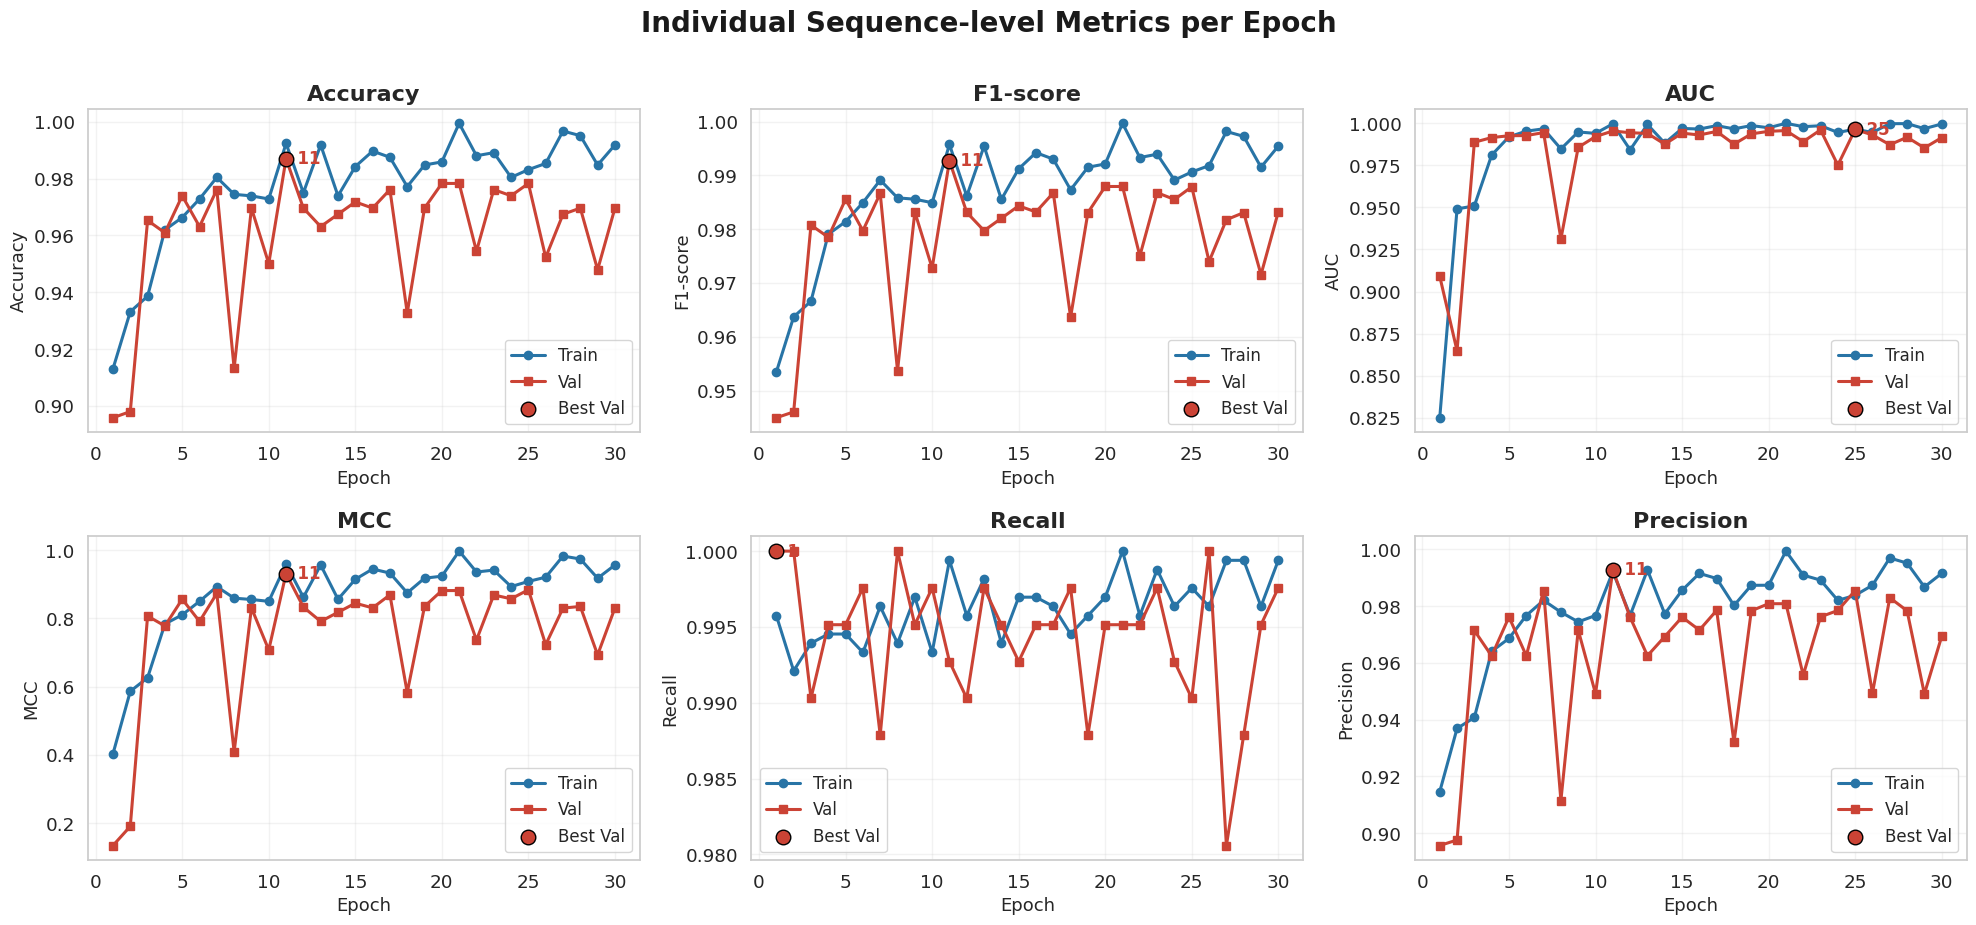

In [ ]:
# ---------- 1. 단일 얼굴(Train/Val) ----------
fig, axes = plt.subplots(3, 2, figsize=(20, 9))

# 6가지 지표
titles = ['Accuracy', 'F1-score', 'AUC', 'MCC', 'Recall', 'Precision']
metrics = [
    ('train_acc', 'val_acc'),
    ('train_f1', 'val_f1'),
    ('train_auc', 'val_auc'),
    ('train_mcc', 'val_mcc'),
    ('train_rec', 'val_rec'),
    ('train_prec', 'val_prec')
]
train_color = '#2874A6'  # 파랑
val_color = '#CB4335'    # 코랄/빨강

for idx, ax in enumerate(axes.flat):
    tr, va = metrics[idx]
    ax.plot(x, history[tr], label='Train', color=train_color, linewidth=2.2, marker='o', markersize=6)
    ax.plot(x, history[va], label='Val', color=val_color, linewidth=2.2, marker='s', markersize=6)
    ax.set_title(titles[idx], fontsize=16, weight='bold')
    ax.set_xlabel('Epoch', fontsize=13)
    ax.set_ylabel(titles[idx], fontsize=13)
    ax.grid(alpha=0.25)
    # Best epoch marker
    best_idx = np.argmax(history[va]) if 'loss' not in va else np.argmin(history[va])
    ax.scatter(x[best_idx], history[va][best_idx],
               color=val_color, s=110, edgecolor='black', label='Best Val', zorder=5)
    ax.legend(fontsize=12, loc='best')
    # Best epoch 번호
    ax.text(x[best_idx], history[va][best_idx], f"  {best_idx+1}", va='center', fontsize=12, color=val_color, weight='bold')
plt.suptitle("Individual Sequence-level Metrics per Epoch", fontsize=20, y=1.03, color='#1a1a1a', weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

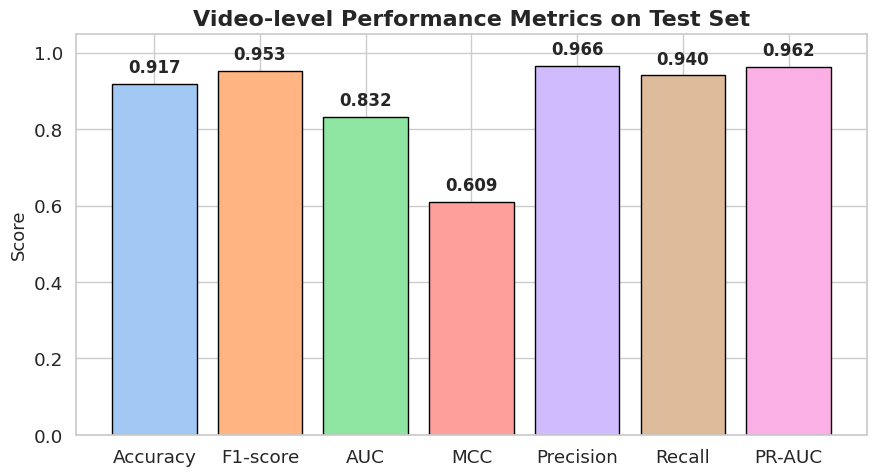

In [16]:
# ---------- 2. 다중 얼굴 비디오 레벨(테스트) ----------
# 테스트(비디오 level) 성능지표 딕셔너리로 정리
test_metrics = {
    "Accuracy": video_acc,
    "F1-score": video_f1,
    "AUC": video_auc,
    "MCC": video_mcc,
    "Precision": video_prec,
    "Recall": video_rec,
    "PR-AUC": video_prc,
}

colors = sns.color_palette("pastel")[:len(test_metrics)]  # 자동 예쁜 색상

plt.figure(figsize=(9, 5))
bars = plt.bar(test_metrics.keys(), test_metrics.values(), color=colors, edgecolor='black')
plt.ylim(0, 1.05)
plt.title("Video-level Performance Metrics on Test Set", fontsize=16, weight='bold')
plt.ylabel("Score", fontsize=13)

# 수치 표기
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02,
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

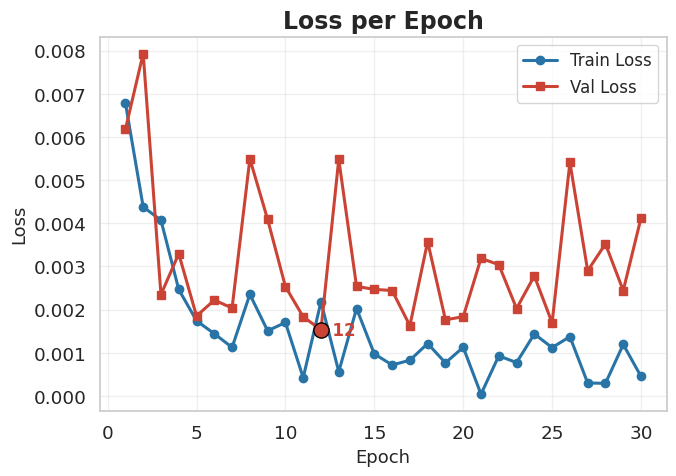

In [ ]:
# ---------- 3. (옵션) Loss 따로 시각화 ----------
plt.figure(figsize=(7, 5))
plt.plot(x, history['train_loss'], label='Train Loss', color=train_color, linewidth=2.2, marker='o', markersize=6)
plt.plot(x, history['val_loss'], label='Val Loss', color=val_color, linewidth=2.2, marker='s', markersize=6)
plt.title('Loss per Epoch', fontsize=17, weight='bold')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
# Best val loss
best_idx = np.argmin(history['val_loss'])
plt.scatter(x[best_idx], history['val_loss'][best_idx],
            color=val_color, s=120, edgecolor='black', label='Best Val Loss', zorder=5)
plt.text(x[best_idx], history['val_loss'][best_idx], f"  {best_idx+1}", va='center', fontsize=12, color=val_color, weight='bold')
plt.tight_layout()
plt.show()

## 혼동행렬

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
# Validation 데이터셋(혹은 test_loader)에서 예측값, 실제값 추출
preds, targets = [], []
probs = []
val_video_ids, val_face_idxs = [], []

with torch.no_grad():
    for video_tensor, label, video_id, face_idx in tqdm(val_loader, desc='Eval [Val set]'):
        video_tensor = video_tensor.to(device)
        out = model(video_tensor)
        prob = out.softmax(-1)[:, 1].cpu().numpy()
        pred_label = (prob > 0.4).astype(int)
        preds += list(pred_label)
        targets += list(label.cpu().numpy())
        probs += list(prob)
        # video_id 등도 저장하려면
        if isinstance(video_id, (list, tuple)):
            val_video_ids += list(video_id)
            val_face_idxs += list(face_idx)
        else:
            val_video_ids.append(video_id)
            val_face_idxs.append(face_idx)

Eval [Val set]: 100%|██████████| 116/116 [00:37<00:00,  3.13it/s]


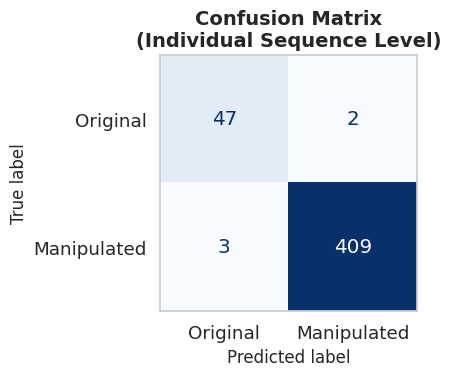

In [22]:
# ---------- 1. 단일 얼굴(Train/Val) ----------

# 예측값 및 타깃은 마지막 validation 루프에서 저장되어 있어야 함
# preds, targets 변수는 validation 루프에서 나옴 (sequence-level)

val_pred_label = [1 if p > 0.5 else 0 for p in preds]  # 예측확률 사용 시
cm_seq = confusion_matrix(targets, val_pred_label)
disp = ConfusionMatrixDisplay(cm_seq, display_labels=['Original', 'Manipulated'])

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix\n(Individual Sequence Level)", fontsize=14, weight='bold')
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

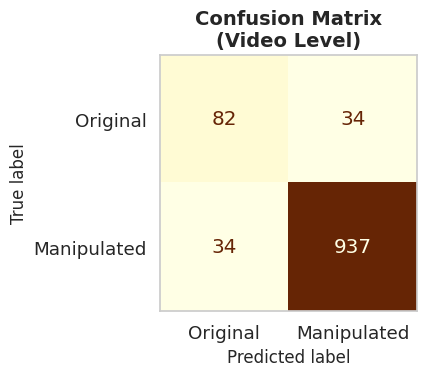

In [25]:
# ---------- 2. 다중 얼굴 비디오 레벨(테스트) ----------
cm_video = confusion_matrix(video_targets, video_preds)
disp_video = ConfusionMatrixDisplay(cm_video, display_labels=['Original', 'Manipulated'])

plt.figure(figsize=(5, 4))
disp_video.plot(cmap='YlOrBr', ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix\n(Video Level)", fontsize=14, weight='bold')
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

## 오분류 샘플

In [26]:
# ---------- 1. 단일 얼굴(Train/Val) ----------

# preds, targets, val_video_ids, val_face_idxs가 validation 루프에서 저장되어야 함
# preds: 시퀀스별 예측(0/1), targets: 시퀀스별 실제값
# val_video_ids, val_face_idxs: 각 샘플의 비디오ID, 얼굴인덱스

mis_idx = [i for i, (t, p) in enumerate(zip(targets, preds)) if t != p]
# (video_id, face_idx, 실제정답, 예측값) 튜플로 정리
misclassified = [
    (val_video_ids[i], val_face_idxs[i], targets[i], preds[i])
    for i in mis_idx
]

print(f"\n[개별 시퀀스 오분류 샘플 수] {len(misclassified)} / {len(targets)}")
print("video_id, face_idx, 실제정답, 예측값")
for v_id, fidx, label, pred in misclassified[:20]:  # 앞 20개만 예시
    print(f"{v_id:30s}  {fidx:2d}  정답: {label}  예측: {pred}")


[개별 시퀀스 오분류 샘플 수] 5 / 461
video_id, face_idx, 실제정답, 예측값
13_11__podium_speech_happy__XXKQ4XM0   0  정답: 1  예측: 0
07_11__hugging_happy__R7R86Z62   0  정답: 1  예측: 0
02__outside_talking_pan_laughing   0  정답: 0  예측: 1
18__walking_down_street_outside_angry   0  정답: 0  예측: 1
02_18__walk_down_hall_angry__B95S4G6F   0  정답: 1  예측: 0


In [27]:
# ---------- 2. 다중 얼굴 비디오 레벨(테스트) ----------

# video_targets, video_preds: 비디오별 실제/예측 레이블
# video_pred_dict: {video_id: [시퀀스별 예측들]}, video_target_dict: {video_id: 실제값}

mis_idx_video = [i for i, (t, p) in enumerate(zip(video_targets, video_preds)) if t != p]
misclassified_video = [
    (list(video_pred_dict.keys())[i], video_targets[i], video_preds[i])
    for i in mis_idx_video
]

print(f"\n[비디오 레벨 오분류 샘플 수] {len(misclassified_video)} / {len(video_targets)}")
print("video_id, 실제정답, 예측값, 시퀀스별 예측")
for v_id, label, pred in misclassified_video[:20]:
    seq_preds = video_pred_dict[v_id]
    print(f"{v_id:30s}  정답: {label}  예측: {pred}  (시퀀스 예측: {seq_preds})")



[비디오 레벨 오분류 샘플 수] 68 / 1087
video_id, 실제정답, 예측값, 시퀀스별 예측
14__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
27__meeting_serious             정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1), np.int64(1)])
09__talking_angry_couch         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
10__talking_angry_couch         정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
18__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
12__talking_angry_couch         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
24__talking_angry_couch         정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
07__talking_angry_couch         정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
23__hugging_happy               정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
26__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
25__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
14__hugging_happ

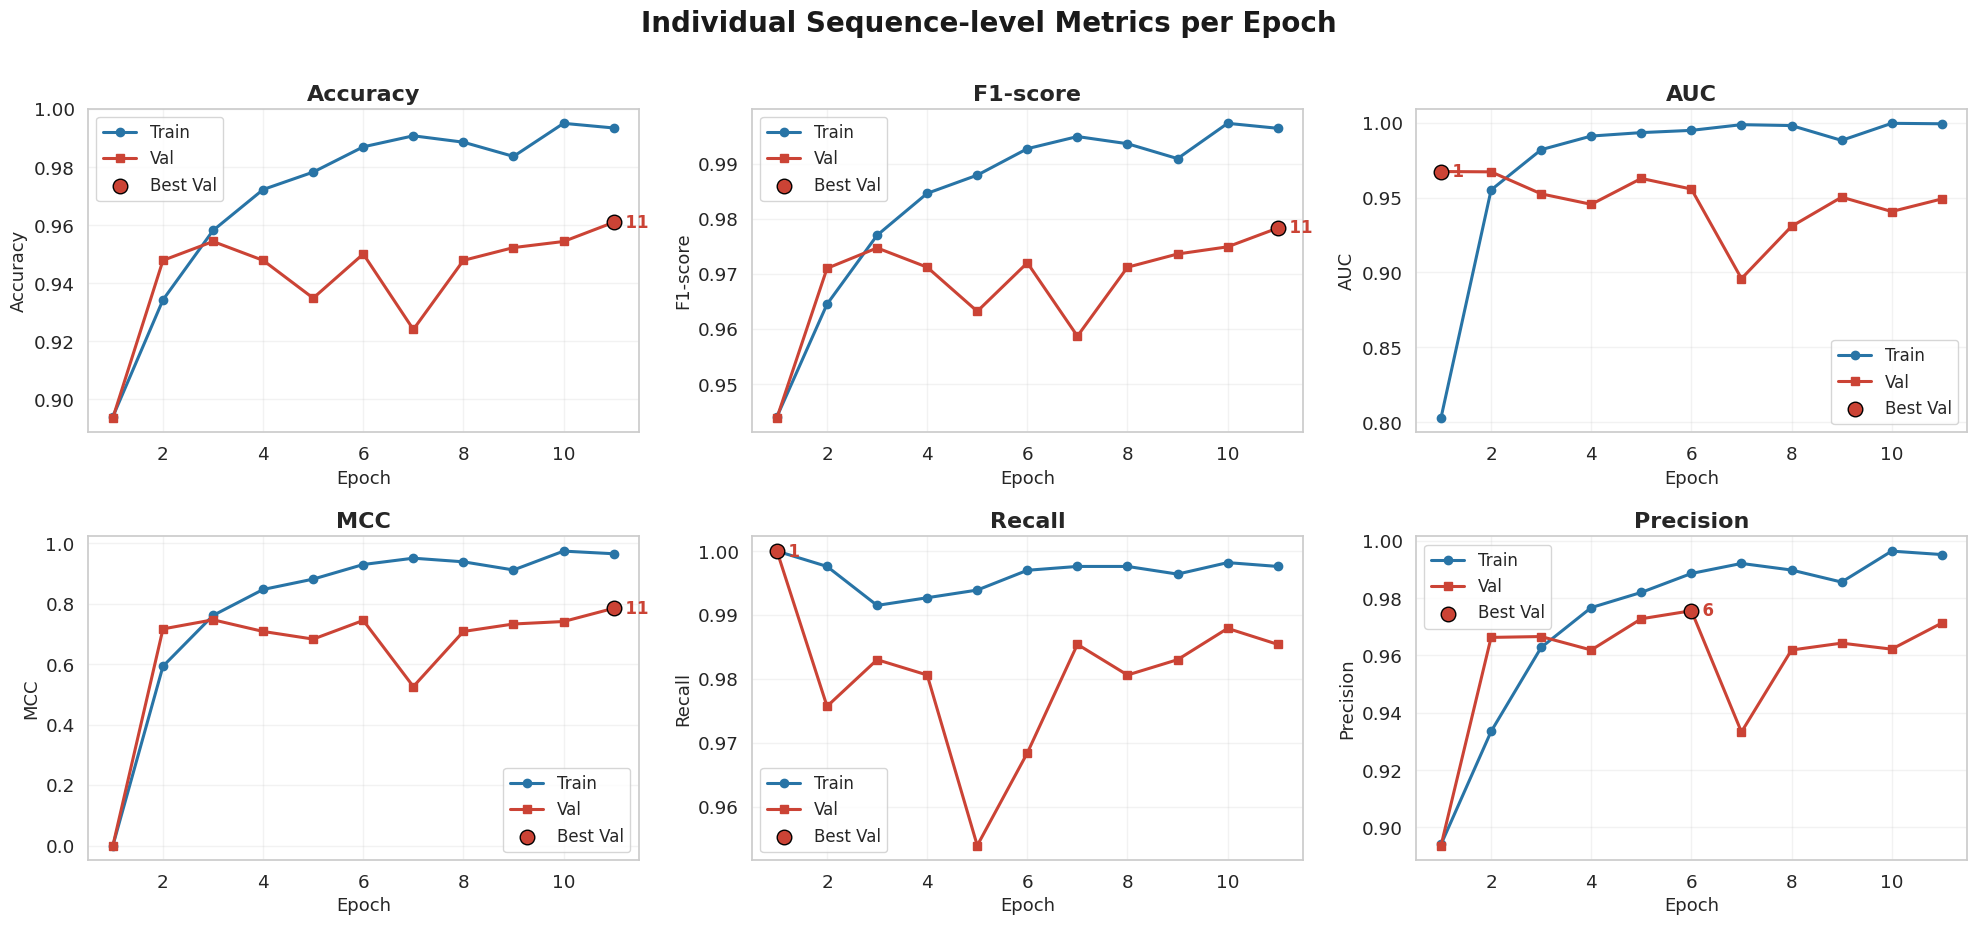

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 로그에서 추출한 11epoch 기준 데이터
history = {
    'train_acc': [0.8941, 0.9343, 0.9582, 0.9723, 0.9783, 0.9870, 0.9908, 0.9886, 0.9837, 0.9951, 0.9935],
    'val_acc':   [0.8937, 0.9479, 0.9544, 0.9479, 0.9349, 0.9501, 0.9241, 0.9479, 0.9523, 0.9544, 0.9610],
    'train_f1':  [0.9441, 0.9645, 0.9770, 0.9846, 0.9879, 0.9927, 0.9949, 0.9936, 0.9909, 0.9973, 0.9964],
    'val_f1':    [0.9439, 0.9710, 0.9747, 0.9712, 0.9632, 0.9720, 0.9587, 0.9712, 0.9736, 0.9749, 0.9783],
    'train_auc': [0.8030, 0.9551, 0.9820, 0.9911, 0.9934, 0.9949, 0.9987, 0.9981, 0.9882, 0.9996, 0.9993],
    'val_auc':   [0.9674, 0.9672, 0.9525, 0.9455, 0.9628, 0.9557, 0.8959, 0.9308, 0.9503, 0.9407, 0.9491],
    'train_mcc': [0.0000, 0.5931, 0.7612, 0.8471, 0.8814, 0.9297, 0.9506, 0.9386, 0.9116, 0.9740, 0.9653],
    'val_mcc':   [0.0000, 0.7166, 0.7468, 0.7082, 0.6829, 0.7447, 0.5259, 0.7082, 0.7329, 0.7411, 0.7848],
    'train_rec': [1.0000, 0.9976, 0.9915, 0.9927, 0.9939, 0.9970, 0.9976, 0.9976, 0.9964, 0.9982, 0.9976],
    'val_rec':   [1.0000, 0.9757, 0.9830, 0.9806, 0.9539, 0.9684, 0.9854, 0.9806, 0.9830, 0.9879, 0.9854],
    'train_prec':[0.8941, 0.9335, 0.9628, 0.9767, 0.9820, 0.9886, 0.9921, 0.9898, 0.9856, 0.9964, 0.9952],
    'val_prec':  [0.8937, 0.9663, 0.9666, 0.9619, 0.9728, 0.9756, 0.9333, 0.9619, 0.9643, 0.9622, 0.9713],
}
x = np.arange(1, 12)  # 1~11 epoch

# 그래프 그리기
fig, axes = plt.subplots(2, 3, figsize=(20, 9))
titles = ['Accuracy', 'F1-score', 'AUC', 'MCC', 'Recall', 'Precision']
metrics = [
    ('train_acc', 'val_acc'),
    ('train_f1', 'val_f1'),
    ('train_auc', 'val_auc'),
    ('train_mcc', 'val_mcc'),
    ('train_rec', 'val_rec'),
    ('train_prec', 'val_prec')
]
train_color = '#2874A6'
val_color = '#CB4335'

for idx, ax in enumerate(axes.flat):
    tr, va = metrics[idx]
    ax.plot(x, history[tr], label='Train', color=train_color, linewidth=2.2, marker='o', markersize=6)
    ax.plot(x, history[va], label='Val', color=val_color, linewidth=2.2, marker='s', markersize=6)
    ax.set_title(titles[idx], fontsize=16, weight='bold')
    ax.set_xlabel('Epoch', fontsize=13)
    ax.set_ylabel(titles[idx], fontsize=13)
    ax.grid(alpha=0.25)
    # Best epoch marker
    best_idx = np.argmax(history[va]) if 'loss' not in va else np.argmin(history[va])
    ax.scatter(x[best_idx], history[va][best_idx],
               color=val_color, s=110, edgecolor='black', label='Best Val', zorder=5)
    ax.legend(fontsize=12, loc='best')
    # Best epoch 번호
    ax.text(x[best_idx], history[va][best_idx], f"  {best_idx+1}", va='center', fontsize=12, color=val_color, weight='bold')

plt.suptitle("Individual Sequence-level Metrics per Epoch", fontsize=20, y=1.03, color='#1a1a1a', weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()